In [66]:
# Cell 1: Import Required Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

# For handling annotations
import xml.etree.ElementTree as ET

# For image display in notebook
from IPython.display import display


import warnings
warnings.filterwarnings('ignore')

In [68]:
# Cell 2: Define Data Paths

# Full vehicle images and their bounding box annotations
vehicle_img_dir = 'license_plates_detection_train/'  # 900 full car images folder
vehicle_ann_file = 'Licplatesdetection_train.csv'  # CSV file with bounding box coordinates for license plates

# Cropped license plate images and their corresponding text labels
plate_img_dir = 'license_plates_recognition_train/'  # 900 license plate images folder
plate_ann_file = 'Licplatesrecognition_train.csv'  # CSV with license plate text labels

# Test set images
test_img_dir = 'test/test/'  # 201 test images


In [70]:
def load_vehicle_annotations(csv_file):
    """
    Reads bounding box annotations from a CSV file.
    Cleans filename keys to avoid KeyErrors.
    """
    df = pd.read_csv(csv_file)  # Load annotation CSV into a DataFrame
    ann_dict = {}

    # Iterate through each row to build a dictionary of annotations
    for _, row in df.iterrows():
        fname = row['img_id'].strip().lower()  # Normalize filename (remove whitespace, convert to lowercase)

        # Store bounding box coordinates as a list of integers
        ann_dict[fname] = [
            int(row['xmin']),
            int(row['ymin']),
            int(row['xmax']),
            int(row['ymax'])
        ]

    return ann_dict  # Return dictionary: {filename -> [xmin, ymin, xmax, ymax]}


In [72]:
from tqdm import tqdm  # For displaying a progress bar during iteration
import os
import cv2  # OpenCV for image processing

# Load vehicle annotations from a file
vehicle_annotations = load_vehicle_annotations(vehicle_ann_file)

vehicle_images = []           # List to store original full vehicle images
license_plate_crops = []      # List to store cropped license plate regions

# Iterate over each file in the vehicle image directory with a progress bar
for filename in tqdm(os.listdir(vehicle_img_dir)):
    if filename.lower().endswith(('.jpg', '.png')):
        # Normalize filename to lowercase and strip whitespaces to match annotation keys
        normalized_filename = filename.strip().lower()

        if normalized_filename not in vehicle_annotations:
            continue  # Skip if no annotation for this image

        img_path = os.path.join(vehicle_img_dir, filename)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Crop license plate using bounding box coordinates
        xmin, ymin, xmax, ymax = vehicle_annotations[normalized_filename]
        cropped_plate = image[ymin:ymax, xmin:xmax]

        # Store the original image and the cropped license plate
        vehicle_images.append(image)
        license_plate_crops.append(cropped_plate)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:01<00:00, 549.75it/s]


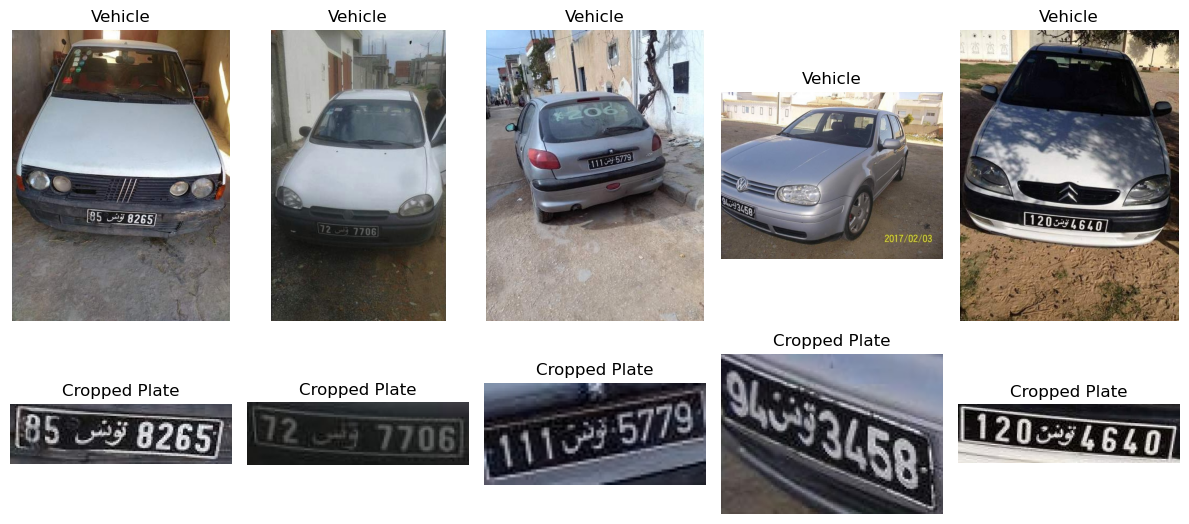

In [74]:
# Cell 5: Visualize Some Detected License Plates

# Create a figure with specified size
plt.figure(figsize=(12, 6))

# Display first 5 vehicle images and their corresponding license plate crops
for i in range(5):
    
    # Show the full vehicle image
    plt.subplot(2, 5, i+1)
    plt.imshow(vehicle_images[i])
    plt.title("Vehicle")
    plt.axis('off')

    # Show the cropped license plate below the corresponding vehicle
    plt.subplot(2, 5, i+6)
    plt.imshow(license_plate_crops[i])
    plt.title("Cropped Plate")
    plt.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [106]:
#EDA – Bounding Box Statistics
# Read CSV
df_bbox = pd.read_csv(vehicle_ann_file)

# Add width and height
df_bbox['width'] = df_bbox['xmax'] - df_bbox['xmin']
df_bbox['height'] = df_bbox['ymax'] - df_bbox['ymin']

# Basic stats
print("Bounding Box Width Stats:\n", df_bbox['width'].describe())
print("\nBounding Box Height Stats:\n", df_bbox['height'].describe())


Bounding Box Width Stats:
 count    900.000000
mean     128.705556
std       50.294405
min       25.000000
25%       96.000000
50%      122.000000
75%      157.000000
max      392.000000
Name: width, dtype: float64

Bounding Box Height Stats:
 count    900.000000
mean      48.144444
std       33.908094
min       13.000000
25%       30.000000
50%       38.500000
75%       53.000000
max      281.000000
Name: height, dtype: float64


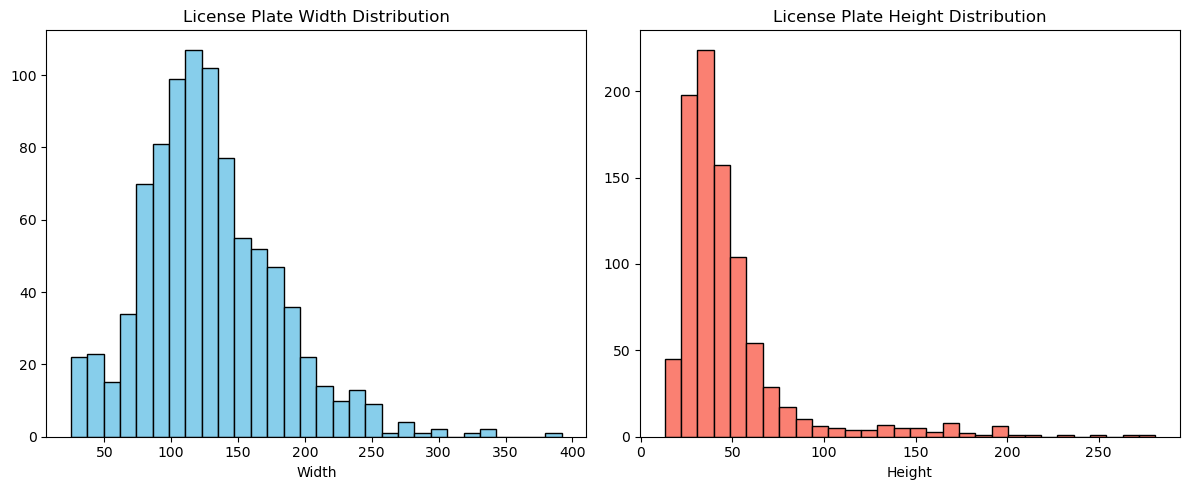

In [104]:
#EDA – Plot Box Dimensions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df_bbox['width'], bins=30, color='skyblue', edgecolor='black')
plt.title('License Plate Width Distribution')
plt.xlabel('Width')

plt.subplot(1, 2, 2)
plt.hist(df_bbox['height'], bins=30, color='salmon', edgecolor='black')
plt.title('License Plate Height Distribution')
plt.xlabel('Height')

plt.tight_layout()
plt.show()


In [102]:
# Cell 6: Load License Plate Images and Text Labels
plate_images = []
plate_texts = []

# Assuming CSV with filename and text
df = pd.read_csv(plate_ann_file)  # Should have columns: filename, text

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_file = row['img_id']
    text = row['text']

    img_path = os.path.join(plate_img_dir, img_file)
    
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plate_images.append(img)
        plate_texts.append(text)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 4966.59it/s]


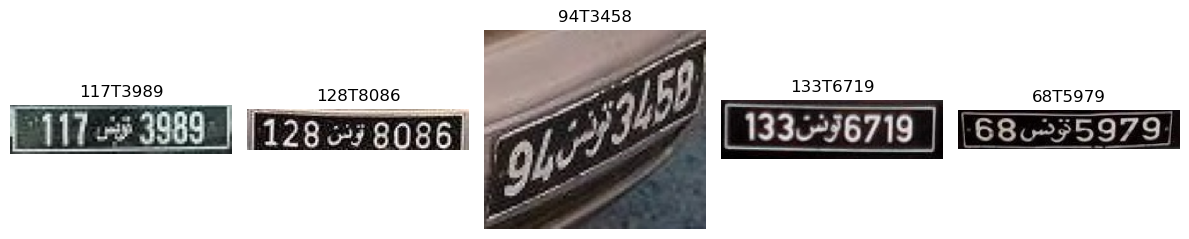

In [78]:
# Cell 7: Visualize Plates and Text

# Create a figure to display license plate images and their corresponding text labels
plt.figure(figsize=(12, 6))

# Show the first 5 license plate images with their text as titles
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(plate_images[i])
    plt.title(plate_texts[i])  # Display license plate text above each image
    plt.axis('off')  # Hide axes for cleaner visualization

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()


In [80]:
# Resize all images to a fixed size suitable for CNN input
img_height, img_width, channels = 64, 128, 3
max_label_len = 10  # Maximum number of characters in a license plate

# Create character vocabulary from dataset (uppercase)
vocab = sorted(set(''.join(plate_texts).upper()))
vocab_size = len(vocab) + 1  # +1 for padding (0 reserved for padding)
char_to_idx = {char: idx+1 for idx, char in enumerate(vocab)}  # Map each char to index
idx_to_char = {idx: char for char, idx in char_to_idx.items()}  # Reverse mapping

# Function to encode a text label into a fixed-length integer sequence
def encode_label(label):
    label = label.upper()
    encoded = [char_to_idx[c] for c in label if c in char_to_idx]
    padded = encoded + [0] * (max_label_len - len(encoded))  # Pad with zeros
    return padded[:max_label_len]  # Ensure fixed length

# Prepare training input images: resize and normalize
X_train = np.array([cv2.resize(img, (img_width, img_height)) for img in plate_images])
X_train = X_train.astype('float32') / 255.0  # Normalize pixel values to [0, 1]

# Prepare training labels: encode and pad
y_train = np.array([encode_label(txt) for txt in plate_texts])
y_train = np.expand_dims(y_train, -1)  # Add extra dimension for compatibility with loss functions


In [82]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, RepeatVector, TimeDistributed

# Encoder: CNN to extract features from license plate image
image_input = Input(shape=(img_height, img_width, channels), name='image_input')

x = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)  # Conv layer 1
x = MaxPooling2D((2, 2))(x)  # Downsample

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)  # Conv layer 2
x = MaxPooling2D((2, 2))(x)  # Downsample again

x = Flatten()(x)  # Flatten 2D features into 1D vector
encoded = Dense(256, activation='relu')(x)  # Dense layer to create feature embedding

# Decoder: RNN to generate character sequence from encoded features
repeated = RepeatVector(max_label_len)(encoded)  # Repeat vector for each time step
decoded = LSTM(256, return_sequences=True)(repeated)  # LSTM processes sequence

# Output layer: predict character probabilities at each time step
outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoded)

# Define and compile the model
model = Model(inputs=image_input, outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()  # Print model architecture


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 64, 128, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 128, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 13)         │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,936,909 (34.09 MB)

 Trainable params: 8,936,909 (34.09 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.2739 - loss: 2.3794 - val_accuracy: 0.4156 - val_loss: 1.9695
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.4324 - loss: 1.8865 - val_accuracy: 0.4344 - val_loss: 1.8011
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.4412 - loss: 1.7596 - val_accuracy: 0.4378 - val_loss: 1.7041
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.4554 - loss: 1.6661 - val_accuracy: 0.4511 - val_loss: 1.6794
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.4631 - loss: 1.6120 - val_accuracy: 0.4556 - val_loss: 1.6367
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.4791 - loss: 1.5368 - val_accuracy: 0.4722 - val_loss: 1.5571
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5020 - loss: 1.4558 - val_accuracy: 0.4778 - val_loss: 1.4997
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.5408 - loss: 1.3430 - val_accuracy: 0.4722 - v

In [86]:
# Collect all test image file paths with .jpg or .png extensions
test_image_paths = [os.path.join(test_img_dir, fname) 
                    for fname in os.listdir(test_img_dir) 
                    if fname.lower().endswith(('.jpg', '.png'))]
print("Number of test images:", len(test_image_paths))

def predict_plate_text(image_path):
    # Load and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_width, img_height))           # Resize to model input size
    img = img.astype('float32') / 255.0                      # Normalize pixel values
    img = np.expand_dims(img, axis=0)                         # Add batch dimension

    # Predict character probabilities for each time step
    pred = model.predict(img)
    pred_indices = [np.argmax(char) for char in pred[0]]     # Take argmax to get predicted indices

    # Convert indices to characters, ignoring padding index 0
    pred_text = ''.join([idx_to_char[idx] for idx in pred_indices if idx > 0])
    return pred_text.strip()                                  # Remove any extra whitespace

# Run prediction on first 10 test images and print results
for path in test_image_paths[:10]:
    print(f"{os.path.basename(path)} --> {predict_plate_text(path)}")


Number of test images: 210
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1019.jpg --> 17T5091
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1025.jpg --> 14TT901
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1031.jpg --> 14T888
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
957.jpg --> 17T5999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
943.jpg --> 17T5799
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
994.jpg --> 17TT599
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
981.jpg --> 130T9033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
995.jpg --> 77T8777
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
942.jpg --> 177T9637
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
956.jpg --> 138T8099


In [88]:
import csv

# Prepare list of test image file paths (jpg/png only)
test_image_paths = [os.path.join(test_img_dir, fname) 
                    for fname in os.listdir(test_img_dir) 
                    if fname.lower().endswith(('.jpg', '.png'))]

def predict_plate_text(image_path):
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_width, img_height))       # Resize to model input size
    img = img.astype('float32') / 255.0                  # Normalize pixel values
    img = np.expand_dims(img, axis=0)                     # Add batch dimension

    # Predict character probabilities
    pred = model.predict(img)
    pred_indices = [np.argmax(char) for char in pred[0]] # Get predicted character indices
    pred_text = ''.join([idx_to_char[idx] for idx in pred_indices if idx > 0])  # Decode indices to text
    return pred_text.strip()

# Path for saving predictions CSV file
output_csv_path = 'test_predictions.csv'

# Write predictions to CSV file with headers: image_id, predicted_text
with open(output_csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_id', 'predicted_text'])  # Write CSV header
    
    # Loop through test images and save predictions
    for img_path in test_image_paths:
        img_id = os.path.basename(img_path)
        prediction = predict_plate_text(img_path)
        writer.writerow([img_id, prediction])

print(f"Predictions saved to {output_csv_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

In [90]:
from IPython.display import FileLink

# Create a clickable link to download/view the generated CSV file in Jupyter Notebook
FileLink('test_predictions.csv')


/Users/hemanth/Downloads/Number Plate Recognization/test_predictions.csv